## 1. Regularized Linear Regression

### 1.1 visualizing the dataset

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat 
import scipy.optimize as opt

In [93]:
data = loadmat('ex5data1.mat')
data

{'X': array([[-15.93675813],
        [-29.15297922],
        [ 36.18954863],
        [ 37.49218733],
        [-48.05882945],
        [ -8.94145794],
        [ 15.30779289],
        [-34.70626581],
        [  1.38915437],
        [-44.38375985],
        [  7.01350208],
        [ 22.76274892]]), 'Xtest': array([[-33.31800399],
        [-37.91216403],
        [-51.20693795],
        [ -6.13259585],
        [ 21.26118327],
        [-40.31952949],
        [-14.54153167],
        [ 32.55976024],
        [ 13.39343255],
        [ 44.20988595],
        [ -1.14267768],
        [-12.76686065],
        [ 34.05450539],
        [ 39.22350028],
        [  1.97449674],
        [ 29.6217551 ],
        [-23.66962971],
        [ -9.01180139],
        [-55.94057091],
        [-35.70859752],
        [  9.51020533]]), 'Xval': array([[-16.74653578],
        [-14.57747075],
        [ 34.51575866],
        [-47.01007574],
        [ 36.97511905],
        [-40.68611002],
        [ -4.47201098],
        [ 26.533

> 1. a training set: X, y
    
> 2. a cross validation set: Xval, yval
    
> 3. a test set: xtest, ytest

In [194]:
def load_data(data):    
    X = data['X']
    Xtest = data['Xtest']
    Xval = data['Xval']
    y = data['y']
    ytest = data['ytest']
    yval = data['yval']
    return X, Xtest, Xval, y, ytest, yval
X, Xtest, Xval, y, ytest, yval = load_data(data)
# 增加常数项
X, Xval, Xtest = [np.insert(item, 0, np.ones(item.shape[0]), axis=1) for item in (X, Xval, Xtest)]
X.shape, y.shape

((12, 2), (12, 1))

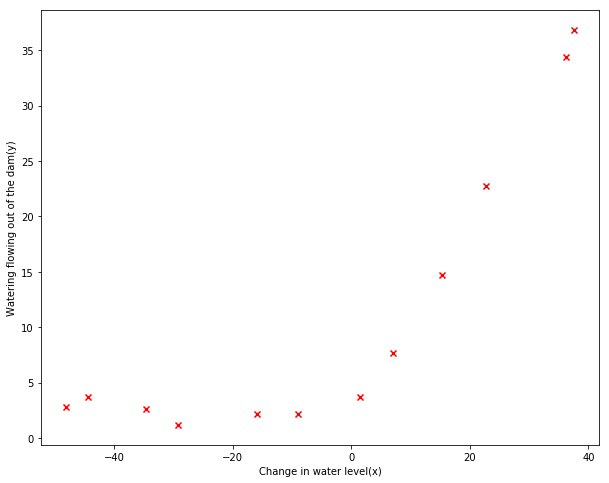

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X, y, c='red', marker='x')
plt.xlabel('Change in water level(x)')
plt.ylabel('Watering flowing out of the dam(y)')
plt.show()

### 1.2 Regularized linear regression ost function

regularized linear regression cost function:
$J\left( \theta \right) =\dfrac {1}{2m}\sum ^{m}_{i=1}\left( h_{\theta }\left( x^\left({i}\right)\right) -y\left( i\right)\right)^{2}+\dfrac {\lambda}{2m}\left( \sum ^{n}_{i=1}\theta ^{2}_{j}\right) $

In [82]:
def regularized_cost(X, y, theta, learning_rate=1):
    """
    X: (m, n)
    y: (m, 1)
    theta: (n, 1), linear regression parameters
    learning_rate: regularized parameter
    """
    m = X.shape[0]
    
    X = np.mat(X)
    y = np.mat(y)
    theta = np.mat(theta)
    
    inner = X * theta - y
    square_sum = inner.T * inner # (1, m) * (m, 1) -> (1, 1)
    cost = square_sum / (2 * m) + (learning_rate) / (2 * m) * (theta[1:].T * theta[1:])
    
    return np.ravel(cost)[0]

In [83]:
m, n = X.shape
theta = np.ones((n, 1))
regularized_cost(X, y, theta)

303.99319222026429

### 1.3 regularized linear regression gradient

j=0：
$\dfrac {\partial J\left( \theta \right) }{\partial \theta _{0}}=\dfrac {1}{m}\sum ^{m}_{i=1}\left( h_{\theta }\left( x^\left({i}\right)\right) -y\left( i\right)\right)x_{j}\left( i\right)$

j>=1：
$\dfrac {\partial J\left( \theta \right) }{\partial \theta _{0}}=\dfrac {1}{m}\sum ^{m}_{i=1}\left( h_{\theta }\left( x^\left({i}\right)\right) -y\left( i\right)\right)x_{j}\left( i\right)+\dfrac {\lambda}{m}\theta _{j}$

In [15]:
def regularized_gradient(X, y, theta, learning_rate=1):
    m = X.shape[0]
    
    X = np.mat(X)
    y = np.mat(y)
    theta_copy = theta.copy()
    theta_copy = np.mat(theta_copy)
    inner = X.T * (X * theta - y)
    
    theta_copy[0] = 0
    gradient = inner / m + (learning_rate) / m * theta_copy
    return gradient

In [16]:
regularized_gradient(X, y, theta)

matrix([[ -15.30301567],
        [ 598.25074417]])

### 1.4 fitting linear regression

In [58]:
# set regularization parameters to 0
def linear_regression(X, y, theta, learning_rate=0, alpha=0.002, iter_nums=500):
    m = X.shape[0]
    
    for i in range(iter_nums):
        theta -= alpha * regularized_gradient(X, y, theta)
    return theta

In [59]:
theta = np.ones((n, 1))
final_theta = linear_regression(X, y, theta)
final_theta

array([[ 8.50910536],
       [ 0.34028484]])

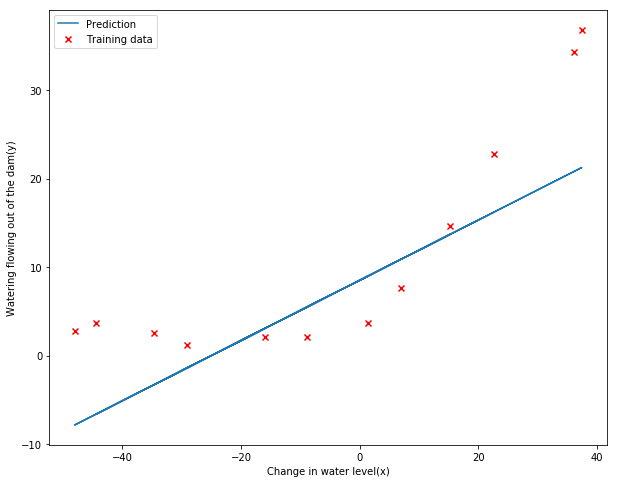

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X[:, 1], y, c='r', marker='x', label="Training data")
plt.plot(X[:, 1],np.dot(X, final_theta), label="Prediction")
plt.xlabel('Change in water level(x)')
plt.ylabel('Watering flowing out of the dam(y)')
plt.legend(loc='best')
plt.show()

## 2. Bias-variance

> 机器学习中一个很重要的概念就是bias-variance，具有high bias的模型不够复杂，倾向于underfit，而high variance模型则通常会overfit

### 2.1 learing curves

绘制learning curves，我们需要training set和cross validation set

$J_{train}\left( \theta \right) =\dfrac {1}{2m}\left[ \sum ^{m}\left(h_{\theta }\left( x^{i}\right) -y\left( i\right)\right) ^{2}\right]$

In [219]:
def plot_learning_curves(X, y, Xval, yval, learning_rate=0):
    training_cost = []
    cv_cost = []
    m, n = X.shape
    for i in range(1, m + 1):
        theta = np.ones((n, 1))
        res = linear_regression(X[:i, :], y[:i], theta, learning_rate=learning_rate, alpha=0.001, iter_nums=500)

        tc = regularized_cost(X[:i, :], y[:i], res, learning_rate=learning_rate)
        cv = regularized_cost(Xval, yval, res, learning_rate=learning_rate)

        training_cost.append(tc)
        cv_cost.append(cv)
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(np.arange(1, m+1), training_cost, label='training cost')
    ax.plot(np.arange(1, m+1), cv_cost, label='cv cost')
    plt.legend(loc='best')
    plt.show()

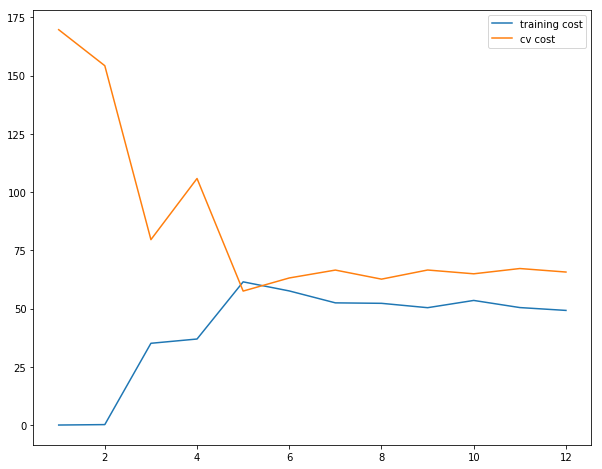

In [195]:
plot_learning_curves()

看图像发现拟合模型具有**high bias**， 说明模型**underfit**

## 3. Polynomial regression

模型太简单，可以通过增加更多特征来弥补

$h_{\theta }\left( x\right) =\theta _{0}+\theta _{1}x_{1}+\ldots +\theta _{p}x_{p}$

In [186]:
def prepare_poly_data(X, power=8):
    for i in range(2, power+1):
        columns = np.power(X[:, 0], i)
        X = np.insert(X, i-1, values=columns, axis=1)
    return X

In [217]:
X, Xtest, Xval, y, ytest, yval = load_data(data)

### 3.1 learning polynomial regression

In [214]:
# 数据的归一化
def normalize_feature(X):
    X =  pd.DataFrame(X)
    return ((X - X.mean()) / X.std()).as_matrix()

In [218]:
X, Xtest, Xval = map(normalize_feature, map(prepare_poly_data, [X, Xtest, Xval]))
# 增加常数项
X, Xval, Xtest = [np.insert(item, 0, np.ones(item.shape[0]), axis=1) for item in (X, Xval, Xtest)]
X

array([[  1.00000000e+00,  -3.62140776e-01,  -7.55086688e-01,
          1.82225876e-01,  -7.06189908e-01,   3.06617917e-01,
         -5.90877673e-01,   3.44515797e-01,  -5.08481165e-01],
       [  1.00000000e+00,  -8.03204845e-01,   1.25825266e-03,
         -2.47936991e-01,  -3.27023420e-01,   9.33963187e-02,
         -4.35817606e-01,   2.55416116e-01,  -4.48912493e-01],
       [  1.00000000e+00,   1.37746700e+00,   5.84826715e-01,
          1.24976856e+00,   2.45311974e-01,   9.78359696e-01,
         -1.21556976e-02,   7.56568484e-01,  -1.70352114e-01],
       [  1.00000000e+00,   1.42093988e+00,   7.06646754e-01,
          1.35984559e+00,   3.95534038e-01,   1.10616178e+00,
          1.25637135e-01,   8.71929081e-01,  -5.96376930e-02],
       [  1.00000000e+00,  -1.43414853e+00,   1.85399982e+00,
         -2.03716308e+00,   2.33143133e+00,  -2.41153626e+00,
          2.60221195e+00,  -2.64567451e+00,   2.76608525e+00],
       [  1.00000000e+00,  -1.28687086e-01,  -9.75968776e-01,
   

### $\lambda =0$

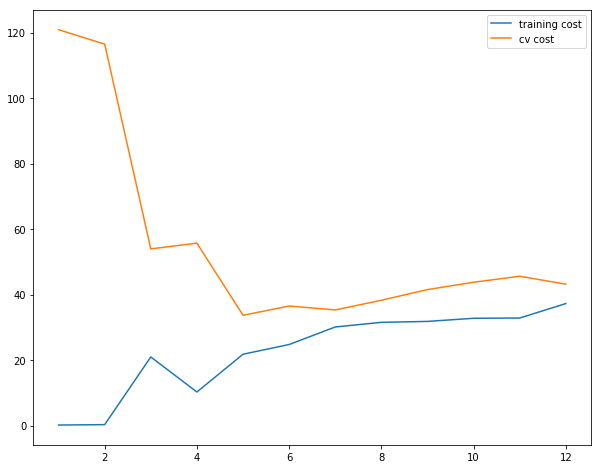

In [220]:
plot_learning_curves(X, y, Xval, yval, learning_rate=0)

### $\lambda =1$

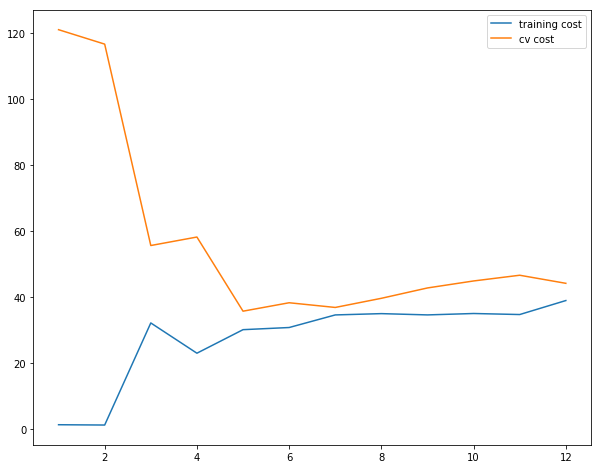

In [221]:
plot_learning_curves(X, y, Xval, yval, learning_rate=1)

### $\lambda =100$

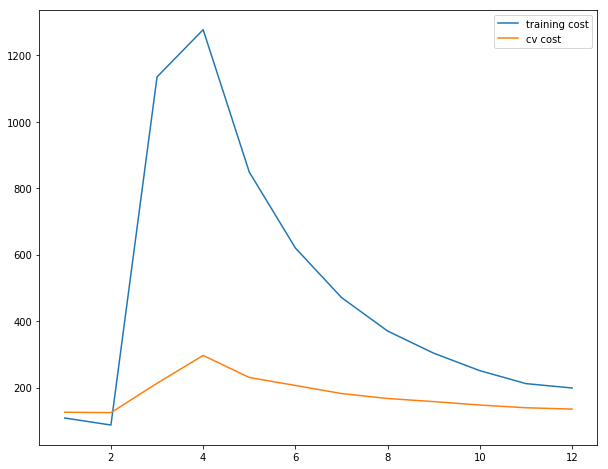

In [223]:
plot_learning_curves(X, y, Xval, yval, learning_rate=100)

### 3.2 selecting $\lambda$ using a cross validation set

In [288]:
candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost = []
cv_cost = []

In [289]:
for i in candidate:
    m, n = X.shape

    theta = np.ones((n, 1))
    res = linear_regression(X, y, theta, learning_rate=i, alpha=0.001, iter_nums=500)

    tc = regularized_cost(X, y, res, learning_rate=i)
    cv = regularized_cost(Xval, yval, res, learning_rate=i)

    training_cost.append(tc)
    cv_cost.append(cv)

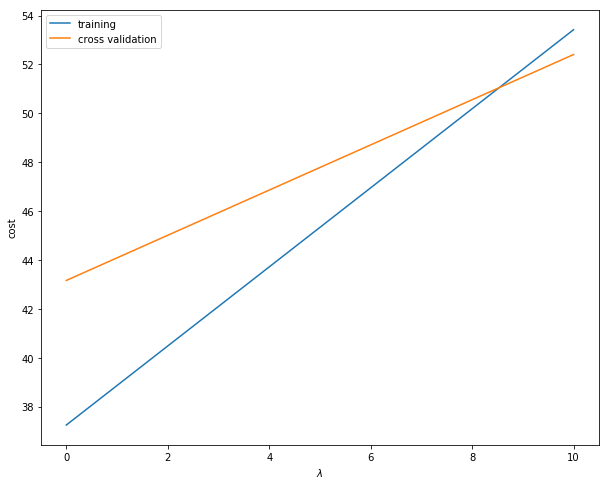

In [290]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(candidate, training_cost, label='training')
ax.plot(candidate, cv_cost, label='cross validation')
plt.legend(loc='best')

plt.xlabel('$\lambda$')
plt.ylabel('cost')
plt.show()

不知道哪一步出了问题，与预想中不太一致，可能是linear reagression函数有问题，官方答案是是$\lambda=3$